# Parallel Processing

*Author: Creare* <br>
*Date: April 01 2020* <br>

**Keywords**: parallel, processing

## Overview

Processing an algorithm pipeline in parallel.

### Prerequisites

- [`podpac[datatype]`](https://podpac.org/install.html#install)
- *Review the [README.md](../../README.md) and [jupyter-tutorial.ipynb](../jupyter-tutorial.ipynb) for additional info on using jupyter notebooks*


### See Also

- [0-concepts/node.ipynb](../0-concepts/node.ipynb): PODPAC Node reference
- [0-concepts/coordinates.ipynb](../0-concepts/coordinates.ipynb): PODPAC Coordinates reference
- [2-combining-data/combining-data-in-algorithm.ipynb](../2-combining-data/combining-data-in-algorithm.ipynb): PODPAC Algorithms

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Get the logger for more detailed output
import logging
logger = logging.getLogger("podpac")

In [3]:
import podpac
from podpac.core.node import Node
from podpac.core.coordinates import Coordinates
import numpy as np

In [4]:
coordinates = podpac.Coordinates(
    [podpac.clinspace(90, -90, 64, 'lat'), podpac.clinspace(-180, 180, 128, 'lon'), 
    podpac.crange('2016-01-01', '2018-01-01', '1,D', 'time')]
)
coordinates

Coordinates (EPSG:4326)
	lat: UniformCoordinates1d(lat): Bounds[-90.0, 90.0], N[64]
	lon: UniformCoordinates1d(lon): Bounds[-180.0, 180.0], N[128]
	time: UniformCoordinates1d(time): Bounds[2016-01-01, 2018-01-01], N[732]

In [5]:
# We will evalute this test node. It just take the sine of the input coordinates
n = podpac.algorithm.SinCoords()

# Wrap it in a "manager", in this case a process. This means the input node "n" will run in a separate process. Alternatively, the "Lambda" manager can be used to run on AWS
np = podpac.managers.Process(source=n)

# Decide how to break up the computation
chunks={'lat':32, 'lon': 64, 'time': 512}

# Create a "Parallel" manager, which will run the input node in multiple Threads
pp = podpac.managers.Parallel(source=np, number_of_workers=4, chunks=chunks)

# Create a "ParallelOutputZarr" manager which will run the input node and put the result into a zarr file
ppzar = podpac.managers.ParallelOutputZarr(source=np, number_of_workers=4, chunks=chunks, zarr_file=r'C:\podpac-2.0.0\test.zarr', init_file_mode='a')

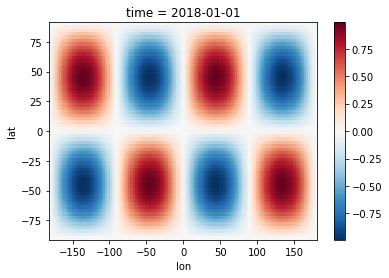

In [6]:
# Evaluate the base node in series
o = n.eval(coordinates)
o[..., -1].plot()
pass

In [7]:
# Evaluate base node in parallel in separate processes
o2 = pp.eval(coordinates)

INFO:podpac.core.managers.parallel:Submitting source 0
INFO:podpac.core.managers.parallel:Submitting source 1
INFO:podpac.core.managers.parallel:Added all chunks to worker pool. Now waiting for results.
INFO:podpac.core.managers.parallel:Submitting source 2
INFO:podpac.core.managers.parallel:Submitting source 3
INFO:podpac.core.managers.parallel:(0:00:00): Waiting for results: 1 / 8
INFO:podpac.core.managers.parallel:Submitting source 4
INFO:podpac.core.managers.parallel:Submitting source 5
INFO:podpac.core.managers.parallel:Submitting source 6
INFO:podpac.core.managers.parallel:Submitting source 7
INFO:podpac.core.managers.parallel:(3.5299532413482666) Finished result: 1 / 8
INFO:podpac.core.managers.parallel:(0:00:03.534000): Waiting for results: 2 / 8
INFO:podpac.core.managers.parallel:(3.535954475402832) Finished result: 2 / 8
INFO:podpac.core.managers.parallel:(0:00:03.538000): Waiting for results: 3 / 8
INFO:podpac.core.managers.parallel:(3.540954828262329) Finished result: 3 / 8

In [8]:
# Evaluate base node in parallel in separate processes and put results in a zarr file. This approach is very useful when working on AWS, as the zarr file can reside in S3. 
ppzar.eval(coordinates)
o3 = ppzar.dataset['data'][:]

INFO:podpac.core.managers.parallel:Added all chunks to worker pool. Now waiting for results.
INFO:podpac.core.managers.parallel:Submitting source 0
INFO:podpac.core.managers.parallel:Submitting source 1
INFO:podpac.core.managers.parallel:Submitting source 2
INFO:podpac.core.managers.parallel:(0:00:00): Waiting for results: 1 / 8
INFO:podpac.core.managers.parallel:Submitting source 3
INFO:podpac.core.managers.parallel:Submitting source 4
INFO:podpac.core.managers.parallel:Submitting source 5
INFO:podpac.core.managers.parallel:Submitting source 6
INFO:podpac.core.managers.parallel:Submitting source 7
INFO:podpac.core.managers.parallel:(3.944930076599121) Finished result: 1 / 8
INFO:podpac.core.managers.parallel:(0:00:03.947000): Waiting for results: 2 / 8
INFO:podpac.core.managers.parallel:(3.9499332904815674) Finished result: 2 / 8
INFO:podpac.core.managers.parallel:(0:00:03.950000): Waiting for results: 3 / 8
INFO:podpac.core.managers.parallel:(3.9549331665039062) Finished result: 3 / 

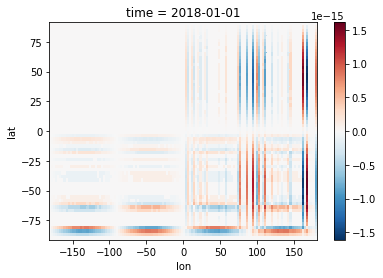

In [9]:
# Compare the original node with the one processed in parallel. They are the same up to floating point precision.
(o-o2)[..., -1].plot()

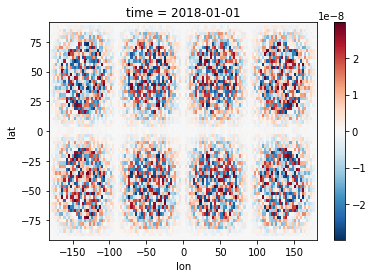

In [10]:
# Compare the original node with the results saved in the zarr file.
(o-o3)[..., -1].plot()

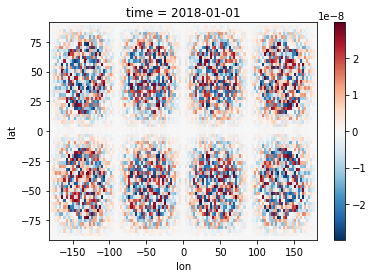

In [11]:
# Compare the parallel computation in-memory with the results saved in the zarr file.
(o2-o3)[..., -1].plot()